An overview of the conformer generation process can be found in [the documentation](https://www.rdkit.org/docs/RDKit_Book.html#introduction).

In [27]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import rdkit
print(rdkit.__version__)

2023.03.1


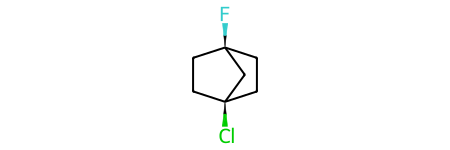

In [40]:
m = Chem.MolFromSmiles('C1C[C@]2(F)CC[C@@]1(Cl)C2')
m

In [41]:
mh = Chem.AddHs(m)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
rdDistGeom.EmbedMolecule(mh,ps)

0

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

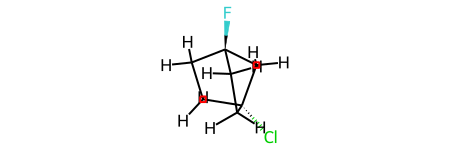

In [42]:
mh

Now invert one of the stereocenters to create the stereoisomer which can't actually exist as a stable structure. Imagine inverting one of the chiral centers in the above molecule and you will see the problem.

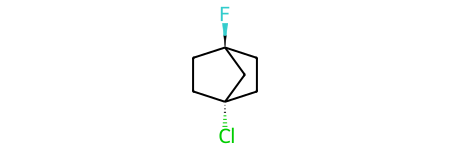

In [43]:
bad_m = Chem.MolFromSmiles('C1C[C@]2(F)CC[C@]1(Cl)C2')
bad_m

Try creating a conformer for that:

In [44]:
bad_mh = Chem.AddHs(bad_m)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
rdDistGeom.EmbedMolecule(bad_mh,ps)

-1

The new functionality allows us to keep track of why the embedding failed:

In [45]:
ps.trackFailures = True
print(rdDistGeom.EmbedMolecule(bad_mh,ps))
ps.GetFailureCounts()

-1


(7, 11, 30, 0, 0, 0, 142, 0, 0, 0)

Here's a quick loop over all the failure causes to see where the problems were:

In [54]:
def print_failure_causes(counts):
    for i,k in enumerate(rdDistGeom.EmbedFailureCauses.names):
        print(k,counts[i])
    # in v2022.03.1 two names are missing from `rdDistGeom.EmbedFailureCauses`:
    print('LINEAR_DOUBLE_BOND',counts[i+1])
    print('BAD_DOUBLE_BOND_STEREO',counts[i+2])    

In [55]:
print_failure_causes(counts)

INITIAL_COORDS 7
FIRST_MINIMIZATION 11
CHECK_TETRAHEDRAL_CENTERS 30
CHECK_CHIRAL_CENTERS 0
MINIMIZE_FOURTH_DIMENSION 0
ETK_MINIMIZATION 0
FINAL_CHIRAL_BOUNDS 142
FINAL_CENTER_IN_VOLUME 0
LINEAR_DOUBLE_BOND 0
BAD_DOUBLE_BOND_STEREO 0


Here's what the individual failures mean:

- `INITIAL_COORDS`: generation of the initial coordinates from the random distance matrix (default) or from a set of random coordinates (when using random coordinate embedding) failed.
- `FIRST_MINIMIZATION`: the initial optimization of the atom positions using the distance-geometry force field failed to produce a low-enough energy conformer. The check here has thresholds for both average energy per atom and the individual atom energies. I'm not providing the threshold values here since the energies from the distance-geometry force field are not physically meaningful - the threshold values are not interpretable.
- `CHECK_TETRAHEDRAL_CENTERS`: at least one tetrahedral C and N centers either has a volume around it which is too small or is outside the volume defined by its neighbors
- `MINIMIZE_FOURTH_DIMENSION`: the minmization to force the values of the fourth-dimensional component of each atom position failed
- `ETK_MINIMIZATION`: after the minimization with the ET and/or K terms, at least one atom which should have been planar was not
- `FINAL_CHIRAL_BOUNDS`: the neighborhood of an atom with specified chirality was too distorted (it violated distance constraints)
- `FINAL_CENTER_IN_VOLUME`: an atom with specified chirality was outside of the volume defined by its neighbors
- `LINEAR_DOUBLE_BOND`: one of the end atoms of a double bond had a linear geometry
- `BAD_DOUBLE_BOND_STEREO`: the stereochemistry of a double bond with specified stereochemistry was wrong in the generated conformer


Let's try a more complicated molecule from ChEMBL

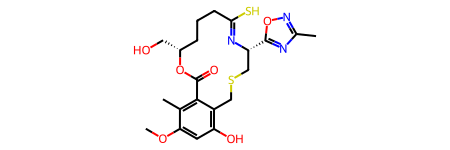

In [79]:
m = Chem.MolFromSmiles(r'COc1cc(O)c2CSC[C@H](\N=C(/S)\CCC[C@@H](CO)OC(=O)c2c1C)c3onc(C)n3')
m

In [80]:
mh = Chem.AddHs(m)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xbadd06
ps.trackFailures = True
print(rdDistGeom.EmbedMolecule(mh,ps))
print_failure_causes(ps.GetFailureCounts())


0
INITIAL_COORDS 7
FIRST_MINIMIZATION 0
CHECK_TETRAHEDRAL_CENTERS 0
CHECK_CHIRAL_CENTERS 0
MINIMIZE_FOURTH_DIMENSION 0
ETK_MINIMIZATION 1
FINAL_CHIRAL_BOUNDS 0
FINAL_CENTER_IN_VOLUME 0
LINEAR_DOUBLE_BOND 18
BAD_DOUBLE_BOND_STEREO 22


This one has a double bond with specified chemistry in the macrocycle that the code has a hard time with (thus the double-bond-related failures)